# CSCA 5632 Final Project - Breast Cancer Type Classification from Gene Expression Data

#### This dataset contains the expression levels of 54,676 genes related to breast cancer. The set includes data for 5 different types of breast cancer plus healthy tissue. The data was downloaded from Kaggle (https://www.kaggle.com/datasets/brunogrisci/breast-cancer-gene-expression-cumida) where it was uploaded by CUMida (https://sbcb.inf.ufrgs.br/cumida). The data references two scientific papers, ([https://doi.org/10.1089/cmb.2018.0238] and [https://doi.org/10.1016/j.jbi.2018.11.013]). This dataset was formed from 78 individual microarray datasets to create one large dataset. The goal of this project will be to classify the data into the breast cancer types using the levels of gene expression as features. Though the data contains labels, my approach will be to use unsupervised learning methods to group the data, using the labels for measuring model accuracy only.

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, root_mean_squared_error, confusion_matrix
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

In [23]:
df = pd.read_csv('Breast_GSE45827.csv')

## EDA and Data Visualization

#### To start, we will take a look at the data 

In [36]:
print(df.info())
print(df.head(5))
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Columns: 54677 entries, samples to AFFX-TrpnX-M_at
dtypes: float64(54675), int64(1), object(1)
memory usage: 63.0+ MB
None
   samples   type  1007_s_at   1053_at    117_at    121_at  1255_g_at  \
0       84  basal   9.850040  8.097927  6.424728  7.353027   3.029122   
1       85  basal   9.861357  8.212222  7.062593  7.685578   3.149468   
2       87  basal  10.103478  8.936137  5.735970  7.687822   3.125931   
3       90  basal   9.756875  7.357148  6.479183  6.986624   3.181638   
4       91  basal   9.408330  7.746404  6.693980  7.333426   3.169923   

    1294_at   1316_at   1320_at  ...  AFFX-r2-Ec-bioD-3_at  \
0  6.880079  4.963740  4.408328  ...             12.229711   
1  7.542283  5.129607  4.584418  ...             12.178531   
2  6.562369  4.813449  4.425195  ...             12.125108   
3  7.802344  5.490982  4.567956  ...             12.111235   
4  7.610457  5.372469  4.424426  ...             12.1736

#### This dataset only has 151 entries, which is very small compared to the number of features.

#### The sum of null values shows that there are no empty entries. The expression levels are already scaled according to the Kaggle write-up of the data. Because of this, no data transformation is necessary.

#### Visualize data distribution

Text(0.5, 1.0, 'Number of Instances of Each Category')

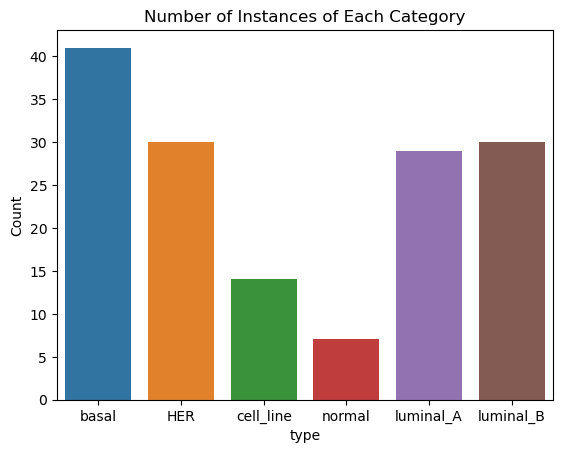

In [25]:
ax = sns.countplot(x = 'type', data = df)
ax.set_ylabel('Count')
ax.set_title('Number of Instances of Each Category')

#### There are a 5 cancer types in this data set and one group of normal cells. The normal group is a much smaller group than the 5 cancer types, and the groups are not very evenly distributed. This could impact model accuracy.

#### Visualize distribution of select features

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Number of Cells at Expression Level')

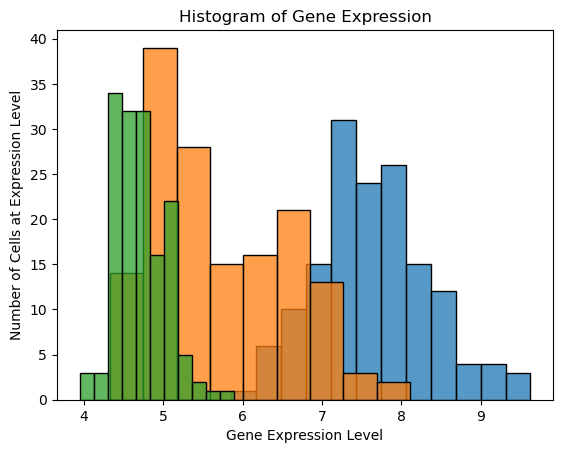

In [38]:
sns.histplot(data = df, x = '1053_at')
sns.histplot(data = df, x = 'AFFX-ThrX-5_at')
sns.histplot(data = df, x = '1320_at')
plt.title('Histogram of Gene Expression')
plt.xlabel('Gene Expression Level')
plt.ylabel('Number of Cells at Expression Level')

#### The distributions of expression levels for these 3 genes is pretty varied. They are all different shapes and cover a different range. 
#### Make histograms of means, mins, and maxs of each feature to show distribution and check for outliers.

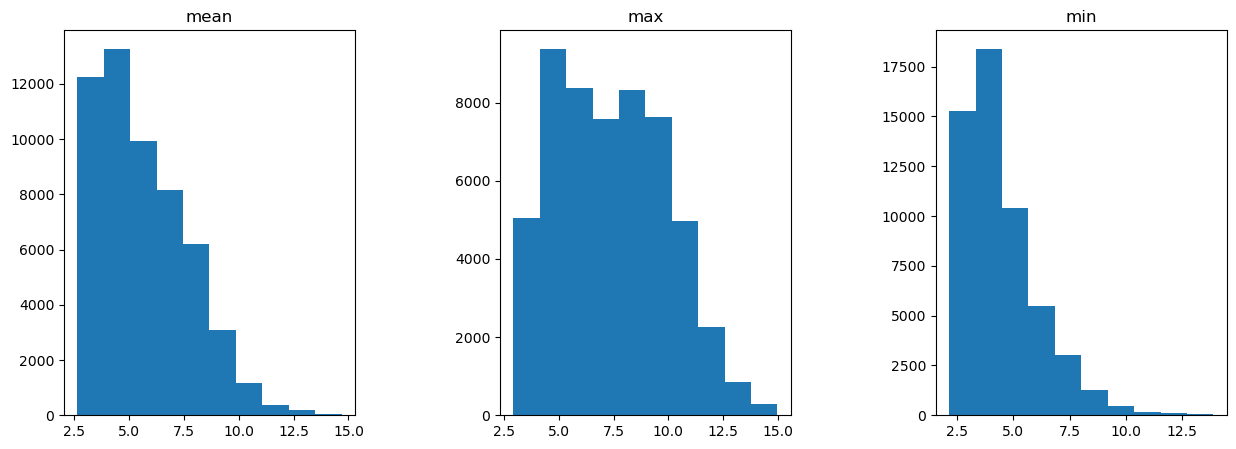

In [66]:
means = df.mean()
maxes = df.max()
mins = df.min()

fig, axs = plt.subplots(nrows=1, ncols=3)
axs[0].hist(means, stacked = True)
axs[0].set_title('mean')
axs[1].hist(maxes, stacked = True)
axs[1].set_title('max')
axs[2].hist(mins, stacked = True)
axs[2].set_title('min')
fig.set_figheight(5)
fig.set_figwidth(15)
plt.subplots_adjust(wspace = 0.5, hspace =0.3)

#### It looks like the dataset may have some outliers since the distributions are skewed slightly.

#### Next, we will clean the data by separating out the 'type' column to use as labels and drop that column along with the samples column since it will not be useful for our analysis. 

In [42]:
labels = df['type']
df = df.drop(columns = ['samples', 'type'])

In [43]:
print(df.head())
print(labels.head())

   1007_s_at   1053_at    117_at    121_at  1255_g_at   1294_at   1316_at  \
0   9.850040  8.097927  6.424728  7.353027   3.029122  6.880079  4.963740   
1   9.861357  8.212222  7.062593  7.685578   3.149468  7.542283  5.129607   
2  10.103478  8.936137  5.735970  7.687822   3.125931  6.562369  4.813449   
3   9.756875  7.357148  6.479183  6.986624   3.181638  7.802344  5.490982   
4   9.408330  7.746404  6.693980  7.333426   3.169923  7.610457  5.372469   

    1320_at  1405_i_at   1431_at  ...  AFFX-r2-Ec-bioD-3_at  \
0  4.408328   8.870780  3.278896  ...             12.229711   
1  4.584418   7.767646  3.589636  ...             12.178531   
2  4.425195   9.417956  3.552253  ...             12.125108   
3  4.567956   9.022345  3.312473  ...             12.111235   
4  4.424426   9.400056  3.368243  ...             12.173642   

   AFFX-r2-Ec-bioD-5_at  AFFX-r2-P1-cre-3_at  AFFX-r2-P1-cre-5_at  \
0             11.852955            13.658701            13.477698   
1             11.809

#### Next, will draw a heatmap to determine correlations between features. Because there are so many features, we will only draw the heatmap for the first 50 to get a feel for how correlated the data may be.

<Axes: >

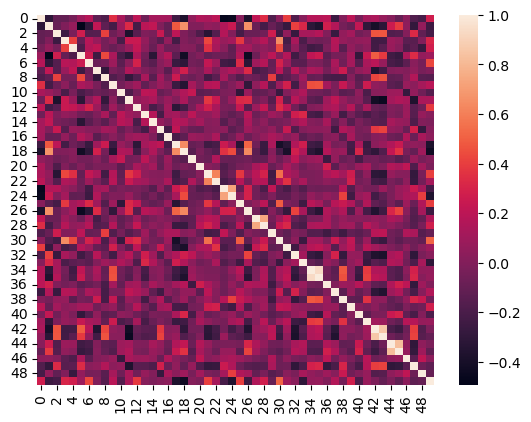

In [48]:
corr_data = df.iloc[:,: 50]
corr = np.corrcoef(corr_data, rowvar = False)
sns.heatmap(corr)

#### The heatmap shows that very few features are strongly correlated. Features 35 and 34 have the strongest correlation, but most features are not very strongly correlated.

## Build Model

#### Will start with a NMF matrix factorization model. I think this is the best unsupervised learning model for this data because it is a good way to classify data by categorizing it into the different groups, and the data is non-negative. I will also define a function for labeling the data for the model.

In [50]:
def predict_from_nmf(model, train_data, train_labels, test_data):
    #returns predicted labels
    W = model.fit_transform(train_data)
    H = model.components_
    categories = np.unique(train_labels)
    cat_to_comp = {}

    for cat in categories:
        avg = W[train_labels == cat].mean(axis=0)
        dominant_comps = np.argsort(avg)[::-1]
        for arg in dominant_comps:
            if arg not in cat_to_comp.values():
                dc = arg
                break
        cat_to_comp[cat] = dc
    
    W_test = model.transform(test_data)

    y_pred = []
    for row in W_test:
        dominant_comp = np.argmax(row)
        cat = [category for category,comp in cat_to_comp.items() if dominant_comp == comp][0]
        y_pred.append(cat)

    return y_pred

In [141]:
base_nmf = NMF(n_components = 6, max_iter = 400)
X_train, X_test, y_train, y_test = train_test_split(df, labels, train_size = 0.7)

y_pred = predict_from_nmf(base_nmf, X_train, y_train, X_test)
acc_bnmf = accuracy_score(y_test,y_pred)
print('accuracy of base NMF model:', acc_bnmf)
confusion_matrix(y_test, y_pred)

accuracy of base NMF model: 0.17391304347826086


array([[ 8,  0,  0,  0,  0,  0],
       [13,  0,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  0,  0],
       [ 0,  5,  0,  0,  0,  0],
       [ 2,  8,  0,  0,  0,  0],
       [ 0,  3,  0,  0,  0,  0]])

#### This model is not very accurate! I will try some hyperparameter tuning to try to increase accuracy.

In [157]:
rand_nmf = NMF(n_components = 6, max_iter = 2000, init = 'random', random_state = 3)
y_pred = predict_from_nmf(rand_nmf, X_train, y_train, X_test)
acc_rnmf = accuracy_score(y_test,y_pred)
print('accuracy of randomized NMF model:', acc_rnmf)
confusion_matrix(y_test, y_pred)

accuracy of randomized NMF model: 0.6304347826086957


array([[6, 0, 0, 1, 1, 0],
       [6, 3, 0, 1, 0, 3],
       [0, 0, 7, 0, 0, 0],
       [0, 0, 0, 5, 0, 0],
       [1, 0, 0, 1, 8, 0],
       [0, 0, 0, 3, 0, 0]])

In [159]:
H_alpha = range(0, 10, 1)
W_alpha = range(0, 10, 1)
accs = []
best_acc = 0
best_h = None
best_w = None

for h in H_alpha:
    for w in W_alpha:
        nmf = NMF(n_components = 6, max_iter = 2000, init = 'random', random_state = 3, alpha_H = h, alpha_W = w)
        y_pred = predict_from_nmf(nmf, X_train, y_train, X_test)
        acc = accuracy_score(y_test,y_pred)
        if acc > best_acc:
            best_acc = acc
            best_h = h
            best_w = w

print('best accuracy:', best_acc)
print('best alpha_h:', best_h)
print('best alpha_w:', best_w)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/lib/p

best accuracy: 0.6304347826086957
best alpha_h: 0
best alpha_w: 0


#### Can also try to improve accuracy by using a larger cut of training data. Will try the best model from the hyperparameter tuning step to test this model.

In [160]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, train_size = 0.8)
nmf = NMF(n_components = 6, max_iter = 2000, init = 'random', random_state = 1, alpha_H = 0, alpha_W = 0)
y_pred = predict_from_nmf(nmf, X_train, y_train, X_test)
acc_tnmf = accuracy_score(y_test,y_pred)
print('accuracy of tuned NMF model:', acc_tnmf)
confusion_matrix(y_test,y_pred)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(


accuracy of tuned NMF model: 0.6774193548387096


array([[7, 1, 0, 0, 2, 0],
       [1, 2, 0, 0, 0, 2],
       [0, 0, 3, 0, 0, 0],
       [0, 0, 0, 6, 0, 0],
       [1, 1, 0, 0, 3, 0],
       [0, 0, 0, 2, 0, 0]])

#### Not too bad of an accuracy score after tuning, but it still could be better. A different model might work better for this data. Will try an agglomerative clustering method and see if it produces better results. Agglomerative clustering does not usually work well with high dimensional data so it likely will not produce better results, but worth a shot.

In [131]:
model=AgglomerativeClustering(n_clusters=6, linkage = 'average')
model.fit(df)

AgglomerativeClustering(linkage='average', n_clusters=6)

In [145]:
import itertools

def label_permute_compare(yt,yp,n=6):
    true_labels = yt.unique().tolist()
    accs = {}
    labels = itertools.permutations(range(n))
    
    for label in labels:
        y = [label[true_labels.index(lab)] for lab in yt]
        acc = accuracy_score(y,yp)
        accs[acc] = label
    max_acc = max(accs.keys())
    max_keys = accs[max_acc]
    
    return max_keys, max_acc

In [146]:
labelorder, acc_ac = label_permute_compare(labels, model.labels_)
print(labelorder, acc_ac)

(1, 5, 0, 4, 3, 2) 0.33774834437086093


In [147]:
true_labels = labels.unique()
yp = model.labels_
yp = [true_labels[labelorder[yp[i]]] for i in range(len(yp))]

confusion_matrix(labels,yp)

array([[ 0,  0,  0,  0, 30,  0],
       [ 0,  0,  0,  0, 41,  0],
       [10,  1,  1,  1,  0,  1],
       [ 0,  0,  0,  0, 29,  0],
       [ 0,  0,  0,  0, 30,  0],
       [ 0,  0,  0,  0,  7,  0]])

In [148]:
metrics = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
linkages = ['ward', 'complete', 'average', 'single']
best_acc = 0
best_model = None
best_met = None
best_link = None

for met in metrics:
    for link in linkages:
        if link == 'ward' and met != 'euclidean':
            continue
        model = AgglomerativeClustering(n_clusters=6, metric = met, linkage = link)
        model.fit(df)
        labelorder, acc = label_permute_compare(labels, model.labels_)
        if acc >= best_acc:
            best_acc = acc
            best_model = model
            best_met = met
            best_link = link

true_labels = labels.unique()
yp = best_model.labels_
yp = [true_labels[labelorder[yp[i]]] for i in range(len(yp))]

print('accuracy:', best_acc)
print('best linkage:', best_link)
print('best_metric:', best_met)
confusion_matrix(labels,yp)
acc_tac = best_acc

accuracy: 0.9072847682119205
best linkage: ward
best_metric: euclidean


#### Even after hyperparameter tuning the agglomerative clustering model is producing an accuracy of 0. This is likely due to the large amount of features with relatively very few data points. We will try KMeans clustering.

In [149]:
kmeans = KMeans(n_clusters = 6)
kmeans.fit(df)
labelorder, acc_km = label_permute_compare(labels, kmeans.labels_)
print(labelorder, acc_km)

(0, 1, 4, 2, 5, 3) 0.7350993377483444


#### KMeans has a similar problem to agglomerative clustering.
#### Next, we will compare these unsupervised approaches to a supervised approach. I will use an SVM model since they can handle data with large feature sets well.

In [161]:
svm = LinearSVC(max_iter = 1500)
svm_mod = svm.fit(X_train, y_train)
svm_score = svm_mod.score(X_test, y_test)
svm_pred = svm_mod.predict(X_test)
print('Supervised learning accuracy score:', svm_score)
confusion_matrix(svm_pred, y_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Supervised learning accuracy score: 0.9032258064516129


array([[8, 0, 0, 0, 0, 0],
       [2, 5, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0],
       [0, 0, 0, 5, 0, 0],
       [0, 0, 0, 1, 5, 0],
       [0, 0, 0, 0, 0, 2]])

#### SVM produced easily the best accuracy score of all models tested. 

## Conclusions

In [162]:
print('Accuracy of base NMF model:', acc_bnmf)
print('Accuracy of randomized NMF model:', acc_rnmf)
print('Accuracy of tuned NMF model:', acc_tnmf)
print('Accuracy of Agglomerative Clustering Model:', acc_ac)
print('Accuracy of tuned Agglomerative Clustering model:', acc_tac)
print('Accuracy of KMeans model:', acc_km)
print('Accuracy of Supervised learning SVM model:', svm_score)

Accuracy of base NMF model: 0.17391304347826086
Accuracy of randomized NMF model: 0.6304347826086957
Accuracy of tuned NMF model: 0.6774193548387096
Accuracy of Agglomerative Clustering Model: 0.33774834437086093
Accuracy of tuned Agglomerative Clustering model: 0.9072847682119205
Accuracy of KMeans model: 0.7350993377483444
Accuracy of Supervised learning SVM model: 0.9032258064516129


#### Models used for this project include NMF, agglomerative clustering, KMeans clustering, and SVM. The unsupervised learning models struggled with this dataset. There are relatively few rows of data for them to learn from. Hyperparameter tuning helped with this, but some models still struggled. The clustering models especially produced accuracy scores of 0 even after hyperparameter tuning. SVM however was very successful and produced a solid model with a decent accuracy score.  

#### The best Unsupervised model was the Agglomerative Clustering model after hyperparameter tuning with an accuracy score of 0.91. The best metric for this was euclidean with ward linkage. The tuned model worked significantly better than the initial model, indicating that the flexibility of this model with the different metric and linkage allowed for improved function. 

#### NMF didn't work super well with this data, likely because of the small amount of data used for training. The model likely overfit due to the huge amount of features and small amount of data, contributing to failed testing. This model also had the longest run time. Increasing the max_iter parameter increased accuracy scores significantly.

#### One reason why the unsupervised models were generally unsuccessful is that the groups were not evenly distributed; some groups had significantly higher numbers of instances than others. This can make it hard for the clustering models to classify some of the groups with fewer instances relative to groups with more instances, skewing the predictive power of the model.

#### The SVM model worked very well with this data. SVM is known to work well with high dimensional data that has many features and few instances, so the success of this model with so many features relative to data points makes sense. 

#### One way this model could be improved is through feature selection. I included all features in these models because selecting features in a systematic way would take a lot of run time and computing power. However, by including all features, I likely allowed overfitting of the models.